                            Yu Zhang, Benjamin Chen, Yuhan Wu

**The following packages are used in this project**

In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

1. **Write a function that loads this file and returns the matrix X and vector y. How many malicious data points are there? What can you say about the sparsity of the data?  Do you think it makes sense to use one-hot-coding for some of the columns?**

we use the following code to loads the data file, returns the matrix X and vector y, and count the number of malicious data points:

In [2]:
class DataLoader:
    def __init__(self, file_path= r".\data\data.csv"):
        self.X = None
        self.y = None
        self.num = 0

        self._read(file_path)

    def _read(self, file_path):
        ori_data = np.loadtxt(file_path, skiprows=1, delimiter=',', dtype=int)
        self.X = ori_data[:,:-1]
        self.y = ori_data[:,-1]
        self.y[self.y == 0] = -1
        self.num = self.X.shape[0]

    def split(self, ratio = 0.7):
        # the number of training data
        train_num = int(self.num * ratio)

        # shuffling the original data
        rand_idx = np.arange(self.num)
        np.random.shuffle(rand_idx)
        X = self.X[rand_idx]
        y = self.y[rand_idx]

        # split the data set
        X_train, X_test = X[:train_num], X[train_num:]
        y_train, y_test = y[:train_num], y[train_num:]

        return X_train, X_test, y_train, y_test

mydata = DataLoader(r".\data\data.csv")
print(f'there are {(mydata.y == 1).sum()} \
malicious data points in the total {mydata.num} data points')

there are 14700 malicious data points in the total 29332 data points


From summing the ones in the data, we get that there are 14700 malicious data points in the total 29332 data points.

The dataset is highly sparse, as most feature values are zero.

For one-hot encoding, it is reasonable to apply it when the features represent categorical data without intrinsic ordering. However, for binary features in our project, one-hot encoding may be redundant unless further categorization is needed.

2. **Write a function that splits the data into a training and test set according to some fraction 0 < r < 1. Make sure to use randomization; that is, it should not be the case that the training set consists of the first data points and the test set of the remaining data points. Your function should return matrices X train and X test and vectors y train and y test.**

We used the `split` method from the `DataLoader` class shown in **Question 1** to divide the dataset according to the given ratio, where shuffling is implemented before spliting to avoid the case that the training set consists of the first data points and the test set of the remaining data points.

In [3]:
np.random.seed(2000)
X_train, X_test, y_train, y_test = mydata.split(ratio = 0.5)

3. **Write a function that, given the matrix X, the vector y, and a weight vector w defining a hyperplane, returns the number of correctly classified points. Verify that the output makes sense for random weight vectors.**

We used a randomly generated weight vector `w_init` to define a hyperplane. The followng function is used to compute predictions and the number of correctly classified points for the given input matrix `X`, output `y`and weight vector `w`.

In [4]:
def evaluator(X: np.ndarray, y: np.ndarray, w: np.ndarray):
    y_pred = X.dot(w)
    y_pred[y_pred < 0] = -1
    y_pred[y_pred >= 0] = 1
    return (y_pred == y).sum()
    
np.random.seed(2000)
w_init = np.random.uniform(low = -1, high = 1, size=(mydata.X.shape[1]))
pred_corr_num = evaluator(mydata.X, mydata.y, w_init)
print(f'{pred_corr_num} data points in total {mydata.num} samples are correct using random generated weights')

13970 data points in total 29332 samples are correct using random generated weights


4. **Consider the cost function for logistic regression as defined in the lectures. Write down a symbolic formula for the gradient of this function.**

The cost function $J(w)$ for logistic regression with regularization is defined as:

$$
J(w) = \sum_{i=1}^{n} L(y_i x_i^T w) + \frac{\lambda}{2} \|w\|^2
$$

where:

$$
L(s) = \log\left(1 + e^{-s}\right)
$$


The gradient of the loss term for a single data point $x_i$ with respect to $w$ is:

$$
\nabla_w L(y_i x_i^T w) = -\frac{y_i x_i}{1 + e^{y_i x_i^T w}}
$$



Therefore, the gradient of the total loss term is:

$$
\sum_{i=1}^{n} \nabla_w L(y_i x_i^T w) = - \sum_{i=1}^{n} \frac{y_i x_i}{1 + e^{y_i x_i^T w}}
$$

The gradient of the regularization term $\frac{\lambda}{2} \| w \|^2$ with respect to $w$ is:

$$
\nabla_w \left( \frac{\lambda}{2} \|w\|^2 \right) = \lambda w
$$



Thus, the gradient of  $J(w)$ with respect to $w$ is:

$$
\nabla_w J(w) = -\sum_{i=1}^{n} \frac{y_i x_i}{1 + e^{y_i x_i^T w}} + \lambda w
$$

5.
    - **Write a straightforward implementation for logistic regression using gradient descent with a fixed step size $\alpha$. Your function should take as arguments the data matrix $X$ and data vector $y$, the step size $\alpha$, the regularization constant $\lambda$, and an integer $K$ indicating the number of gradient descent steps. The function should return a weight vector $w$.**
    - **Experiment with the hyperparameters, using dense and sparse linear algebra, on random splits of training and test data sets. (If you know about writing allocation-free code, you can also experiment with this.)**
    - **Given for instance a 50/50 split between test and training data, what is the best classification performance you can obtain on the test set?**

In assessing the execution time of different implementations of logistic regression, we set the step size $\alpha = 0.01$, regularization constant $\lambda = 0.01$, and the number of gradient descent steps $K = 100$ to test our code.

We implement our logistic regression code in three different ways:

1. The `logistic_regression_entrywise` method calculates the gradient for each data point individually in every iteration.

2. The `logistic_regression_vectorize` method leverages vectorization and broadcasting to avoid explicitly calculating the gradient for each data point, as shown below:

    - `s = y * (X @ w)`
    - `z = y / (1 + np.exp(s))`
    - `w_grad = - (X.T @ z) + lambda_ * w`



3. The `logistic_regression_sparse method` is further optimized by converting the sparse training data `X` to a CSR (Compressed Sparse Row) format and using sparse linear algebra to accelerate the computation of matrix-vector multiplication.

The code implement above is shown as below:

In [5]:
class LogisticClassifier:
    def __init__(self, X_train, y_train, w_init):
        self.X_train = X_train
        self.y_train = y_train
        self.w_init = w_init
        self.w = None

    def logistic_regression(self, K, alpha, lambda_reg, flag = 0):
        if flag == 0:
            self.logistic_regression_entrywise(K, alpha, lambda_reg)
        if flag == 1:
            self.logistic_regression_vectorize(K, alpha, lambda_reg)
        if flag == 2:
            self.logistic_regression_sparse(K, alpha, lambda_reg)

    def logistic_regression_entrywise(self, K, alpha, lambda_reg):
        self.w = self.w_init
        for k in range(K):
            w_grad = lambda_reg * self.w
            for i in range(self.X_train.shape[0]):
                # if k == 5:
                #     print(i)
                w_grad -=(self.y_train[i] * self.X_train[i])\
                /(1 + np.exp(self.y_train[i] * self.X_train[i].dot(self.w)))
            self.w -= w_grad * alpha
        return self.w

    def logistic_regression_vectorize(self, K, alpha, lambda_reg):
        self.w = self.w_init
        for _ in range(K):
            s = self.y_train[:,None] * self.X_train @ self.w
            z = self.y_train / (1 + np.exp(s))
            w_grad = - self.X_train.T @ z + lambda_reg * self.w
            self.w -= w_grad * alpha
        return self.w

    def logistic_regression_sparse(self, K, alpha, lambda_reg):
        self.w = self.w_init
        self.X_train = csr_matrix(self.X_train)
        for _ in range(K):
            s_product = self.X_train @ self.w
            s = self.y_train * s_product
            z = self.y_train / (1 + np.exp(s))
            w_grad = - self.X_train.T @ z + lambda_reg * self.w
            self.w -= w_grad * alpha
        return self.w

    def predict(self, X_test, y_test):
        w = self.w
        y_true =  evaluator(X_test, y_test, w)
        acc = y_true / y_test.shape[0]
        return acc

In [6]:
log_reg = LogisticClassifier(X_train, y_train, w_init)

start = time.time()
log_reg.logistic_regression(K=100, alpha=0.01, lambda_reg=0.01, flag= 0)
accuracy = log_reg.predict(X_test, y_test)
end = time.time()
print(f'Entry-Wise Implement:\n Accuracy on the test set: {accuracy * 100:.2f}%, the time cost is {end-start}s\n')

start = time.time()
log_reg.logistic_regression(K=100, alpha=0.01, lambda_reg=0.01, flag=1)
accuracy = log_reg.predict(X_test, y_test)
end = time.time()
print(f'Dense Implement:\nAccuracy on the test set: {accuracy * 100:.2f}%, the time cost is {end-start}s\n')

start = time.time()
log_reg.logistic_regression(K=100, alpha=0.01, lambda_reg=0.01, flag=2)
accuracy = log_reg.predict(X_test, y_test)
end = time.time()
print(f'Sparse Implement:\nAccuracy on the test set: {accuracy * 100:.2f}%, the time cost is {end - start}s\n')

Entry-Wise Implement:
 Accuracy on the test set: 95.06%, the time cost is 14.156911849975586s

Dense Implement:
Accuracy on the test set: 95.19%, the time cost is 2.609433889389038s

Sparse Implement:
Accuracy on the test set: 95.25%, the time cost is 0.3296694755554199s



From the above experiment, we have:

1. The three implements achieve similar accuracy with different runing times.
 
2. The `logistic_regression_entrywise` method is quite slow for large datasets because of the iterative sample-by-sample gradient computation, taking approximately $14.16$ seconds for 100 iteration.

3. The `logistic_regression_vectorize` method reduces computation time to roughly $2.61$ second for 100 iteration.

4. The `logistic_regression_sparse` method is the fastest with a rapid runtime of $0.33$ seconds for 100 iteration, making it ideal for large, sparse datasets by reducing unnecessary calculations.


After experimenting with different hyperparameters, the best classification performance achieved in $1000$ iterations on test data with $50/50$ split is $95.38\%$, with $\alpha = 0.001$ and $\lambda = 0.0001$ among all tested hyperparameters.

In [7]:
best_alpha = None
best_lambda_reg = None
best_acc = 0
for alpha in [0.1,0.03,0.01,0.003,0.001]:
    for lambda_reg in [0.1,0.01,0.001,0.0001]:
        print(f"Progress: alpha = {alpha}, lambda = {lambda_reg}", end='\r')
        log_reg.logistic_regression(K=1000, alpha=alpha, lambda_reg=lambda_reg, flag=2)
        accuracy = log_reg.predict(X_test, y_test)
        if accuracy >= best_acc:
            best_acc = accuracy
            best_alpha = alpha
            best_lambda_reg = lambda_reg

print(f'best_acc = {best_acc}, best_alpha = {best_alpha}, best_lambda_reg = {best_lambda_reg}\n')

C:\Users\11787\AppData\Local\Temp\ipykernel_10096\3012149010.py:43: RuntimeWarning: overflow encountered in exp
  z = self.y_train / (1 + np.exp(s))


best_acc = 0.9537706259375426, best_alpha = 0.001, best_lambda_reg = 0.0001



6. **Download the file data2.csv. This is the same as the previous data file, except that 2000 fake data points have been appended to the data set. Use the singular value transform as explained in the lecture to detect and remove most of these outliers without removing too many other data points. (For the singular value transform you can use a library function, you do not have to implement this yourself.)**

We use the following function to whitening our data:

In [8]:
def data_whitening(X, k):
    # Centering
    M = X - X.mean(axis=0)

    # SVD Decomposition
    U, S, _ = la.svds(M, k=k)

    # Whitening
    Xw = U[:,::-1] @ scipy.sparse.diags(S[::-1])
    Xw = Xw / np.std(Xw, axis=0)[None,:]

    return Xw

Then we compute the norm of whitenning data to detect the outliers in our data, Within the `noise_removal` function, we employed the `scipy.sparse.linalg.svds` method to compute the top k singular values and their corresponding singular vectors:

In [9]:
def noise_removal(X, k, percentile = 0.9, vis_flag = False):
    # Whitening
    Xw = data_whitening(X, k)

    norm_list = np.array([np.linalg.norm(Xw[i, :]) for i in range(Xw.shape[0])])
    outlier_mask = norm_list >= np.quantile(norm_list, percentile)

    return outlier_mask

Let:

- TP (True positive) = number of fake samples be detected
- FN (False Negative) = number of fake samples be identified as true data points
- TN (True Negative) = number of true data points be correctly identified
- FP (False Positive) = number of true data point be wrongly identified as fake samples.



We use Precision, Recall and F1-score to assess the performance of our method

In [10]:
def assess_performance(outlier_mask, vis_flag = False):
    confusion_matrix, (P, R), F1 = F1_score(outlier_mask)
    acc = (confusion_matrix[0] + confusion_matrix[2]) /\
              (confusion_matrix[0] + confusion_matrix[1] + confusion_matrix[2] + confusion_matrix[3])
    
    if vis_flag:
        visualize_confusion(*confusion_matrix)
        print(f'Accuracy: {acc*100:.2f}%')
        print(f"Precision: {P*100:.2f}%")
        print(f"Recall: {R*100:.2f}%")
        print(f"F1-score: {F1:.4f}")

    return F1, (P, R), acc

def F1_score(outlier_mask, outlier_num = 2000):
    """
    The outlier is in the last #outlier_num rows.
    """

    total_num = len(outlier_mask)

    TP = (outlier_mask[-outlier_num:].sum())
    FP = (outlier_mask[:-outlier_num].sum())

    TN = total_num - outlier_num - FP
    FN = outlier_num - TP

    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    F1_score = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0

    return (TP, FP, TN, FN), (Precision, Recall), F1_score


def visualize_confusion(TP, FP, TN, FN):
    confusion_matrix = np.array([[TN, FP],
                                 [FN, TP]])

    categories = ['Normal', 'Outlier']

    # plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# read data
my_data = DataLoader(r".\data\data2.csv")
X = my_data.X.astype('float64')

The threshold is set based on the percentile of the norms of the whitened data, and we test on different percentile $q$ ranging from $90\%$ to $94\%$ to find the value of $k$ that maximizes the F1-score.

The results show that $k = 85$, $q = 93\%$ has the maximal F1-score.

In [11]:
F1_list = []
best_F1 = 0
best_k = None
best_q = None

for q in np.arange(0.90, 0.95, 0.01):  # test on different values of q
    F1_values = []
    for k in np.arange(1, 86):  # test on different values of k
        print(f"Progress: q={q * 100:.1f}%, k={k}", end='\r')
        F1, _, _ = assess_performance(noise_removal(X, k, q), vis_flag=False)
        F1_values.append(F1)

        # Update best results if current F1 is higher
        if F1 >= best_F1:
            best_F1 = F1
            best_k = k
            best_q = q
    
    F1_list.append(F1_values)

print(f"Best performance: k={best_k} and q={best_q * 100:.0f}% achieve the maximal F1-score of {best_F1:.4f}")

Best performance: k=85 and q=93% achieve the maximal F1-score of 0.8755


The changes of F1-score when $q = 93\%$ with the increasing of $k$ is shown as below:

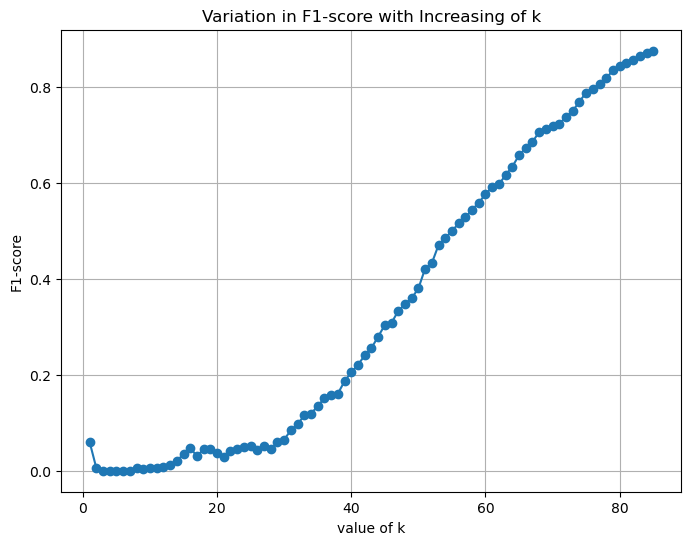

In [12]:
F1_values = F1_list[3]
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 86), F1_values, marker='o')
plt.xlabel("value of k")
plt.ylabel("F1-score")
plt.title("Variation in F1-score with Increasing of k")
plt.grid(True)
plt.show()

The detailed classification result for $q=93\%$ and $k=85$ is shown as below:

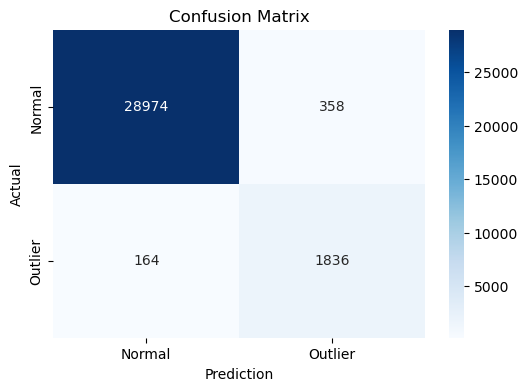

Accuracy: 98.33%
Precision: 83.68%
Recall: 91.80%
F1-score: 0.8755


In [13]:
# data whitening & noise removal
F1, _, _ = assess_performance(noise_removal(X, 85, 0.93), vis_flag=True)

In the plot of confusion matrix, we have:

- The diagonal elements ($28974$ normal points and $1836$ outliers) indicate correctly classified instances.
    
- Off-diagonal elements ($164$ outliers misclassified as normal and $358$ normal samples misclassified as outliers) are the classification errors made by our model.

- Majority of outliers was removed and only a few truer data point was misclassifieds.

By adjusting the threshold $q$ for classifying a data point as an outlier or not, we obtain different classification results, focusing either on detecting more true positives (TP) or on detecting true positives with greater accuracy. The precision-recall curve is shown below：


The PR-Curve for k = 85 is:



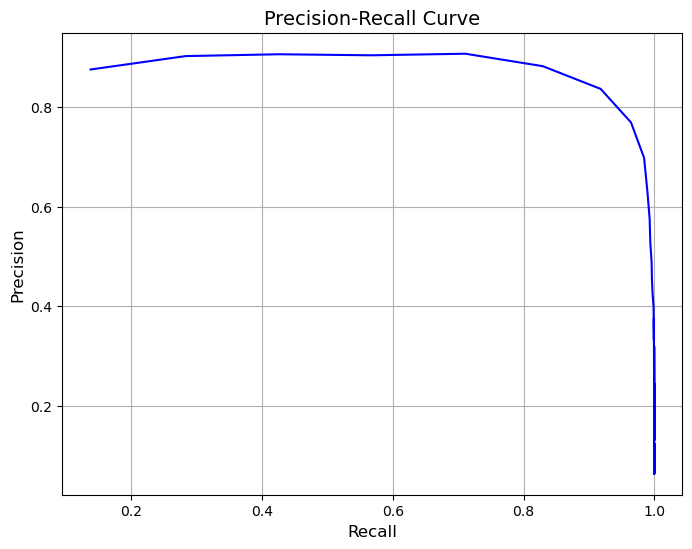

In [14]:
def plot_PRC(P_list, R_list):
    # data clean
    valid_indices = (~np.isnan(P_list)) & (~np.isnan(R_list)) & (~np.isinf(P_list)) & (~np.isinf(R_list))
    P_array = P_list[valid_indices]
    R_array = R_list[valid_indices]

    # sort data
    sorted_indices = np.argsort(R_array)
    R_sorted = R_array[sorted_indices]
    P_sorted = P_array[sorted_indices]

    # plot data
    plt.figure(figsize=(8, 6))
    plt.plot(R_sorted, P_sorted, linestyle='-', color='b')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14)
    plt.grid(True)
    plt.show()

P_list = []
R_list = []
for q in np.arange(0.01, 1.00, 0.01):
    print(f"Progress: {q * 100:.0f}%", end='\r')
    _, (P, R), _ = assess_performance(noise_removal(X, 85, q), vis_flag=False)
    P_list.append(P)
    R_list.append(R)

# plot PR-Curve
print("The PR-Curve for k = 85 is:\n")
plot_PRC(np.array(P_list), np.array(R_list))